In [2]:
#Load relevant pacakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import os, sys, glob, yaml, datetime, argparse
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
#Grab some relevant part of tools.py in qtrkx-gnn-tracking
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

In [4]:
def parse_args():
    # generic parser, nothing fancy here
    parser = argparse.ArgumentParser(description='Load config file!')
    add_arg = parser.add_argument
    add_arg('config')
    add_arg('RID')
    return parser.parse_args()
def load_config(args):
    # read the config file 
    with open(args.config, 'r') as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.FullLoader)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # append RID to log dir
        config['log_dir'] = config['log_dir']+'run{}/'.format(args.RID)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # print all configs
        print('Printing configs: ')
        for key in config:
            print(key + ': ' + str(config[key]))
        print('Log dir: ' + config['log_dir'])
        print('Training data input dir: ' + config['train_dir'])
        print('Validation data input dir: ' + config['train_dir'])
        if config['run_type'] == 'new_run':
            delete_all_logs(config['log_dir'])
    # LOG the config every time
    with open(config['log_dir'] + 'config.yaml', 'w') as f:
        for key in config:
            f.write('%s : %s \n' %(key,str(config[key])))
    # return the config dictionary
    return config

In [11]:
#We will use this in the modified tools.py
def load_graph_(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        temp=dict(f.items())
    X, y, Ri_rows, Ri_cols, Ro_rows, Ro_cols = temp['X'],temp['y'],temp['Ri_rows'],temp['Ri_cols'],temp['Ro_rows'],temp['Ro_cols']
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), np.float32)
    Ro = np.zeros((n_nodes, n_edges), np.float32)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    #Need to change type for later use.
    y,Ri,Ro=y.astype(np.int32),Ri.astype(np.int32),Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = n_nodes, n_edges
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k>0 and k%2000==0: 
            print(k,'-th iteration..')
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)

    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    # Concatenate the two arrays horizontally (along columns)
    coloring = np.reshape(coloring,(-1,1))
    X = np.concatenate((X, coloring), axis=1)
    return Graph(X, Ri, Ro, y)

In [13]:
def load_graph2(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs2')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
#Coloring functions
def graph_coloring2(graph_name):
    graph_ex=load_graph2(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k!=0 and k%3000==0:
            print(k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)
    print("Start greedy coloring for "+graph_name)
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
#Data management functions
def save_color_df2(graph_name,folder):
    X, _, _, _, coloring = graph_coloring2(graph_name)
    X_color = color_df(X,coloring)
    #X_color_red = color_df_red(X,coloring)
    dir_ = os.path.join(os.getcwd(), folder)
    # Ensure that the 'dir_' directory exists; if not, create it
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    # Specify the full file path, including the directory and filename
    graph_name_=graph_name[:-4]
    #graph_name_red = graph_name_+'_red'
    file_path = os.path.join(dir_, f"{graph_name_}.csv")
    #file_path_red = os.path.join(dir_, f"{graph_name_red}.csv")
    # Save the DataFrame as a CSV file
    X_color.to_csv(file_path, index=False)
    print("CSV file saved..")
    #X_color_red.to_csv(file_path_red, index=False)
def file_names(folder):
    # Specify the directory path 
    graph_dir = os.path.join(os.getcwd(), folder)
    # Get a list of all files in the directory
    file_names = os.listdir(graph_dir)
    # filter out only files
    file_names = [f for f in file_names if os.path.isfile(os.path.join(graph_dir, f))]
    return file_names
graph_names2 = file_names("graphs2")

In [ ]:
#Coloring functions
def graph_coloring(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k!=0 and k%3000==0:
            print(k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)
    print("Start greedy coloring for "+graph_name)
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
#Include coloring to the original X data frame
def color_df(original_X,color):
    X_color = pd.DataFrame(original_X,columns=['x','y','z'])
    X_color['color'] = color
    return X_color
#If there are too many data points, reduce.
def color_df_red(original_X,color):
    X_color=color_df(original_X,color)
    X_color['r'] = np.sqrt(X_color['x']**2 + X_color['y']**2)
    X_color_red=X_color[(X_color['z']<0.1)&(X_color['z']>-0.1)
                   &(X_color['y']>0)&(X_color['r']<0.2)]
    return X_color_red

In [14]:
#Data management functions
def save_color_df(graph_name,folder):
    X, _, _, _, coloring = graph_coloring(graph_name)
    X_color = color_df(X,coloring)
    #X_color_red = color_df_red(X,coloring)
    dir_ = os.path.join(os.getcwd(), folder)
    # Ensure that the 'dir_' directory exists; if not, create it
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    # Specify the full file path, including the directory and filename
    graph_name_=graph_name[:-4]
    #graph_name_red = graph_name_+'_red'
    file_path = os.path.join(dir_, f"{graph_name_}.csv")
    #file_path_red = os.path.join(dir_, f"{graph_name_red}.csv")
    # Save the DataFrame as a CSV file
    X_color.to_csv(file_path, index=False)
    print("CSV file saved..")
    #X_color_red.to_csv(file_path_red, index=False)

In [15]:
graph_names = file_names("graphs")
graph_names.remove('.DS_Store')
len(graph_names)

50

In [16]:
def color_X_read(graph_name):
    color_dir = os.path.join(os.getcwd(), 'color')
    # Construct the full path to the specified file
    full_path = os.path.join(color_dir, graph_name)
    colorX=pd.read_csv(full_path)
    return colorX

In [17]:
X_color=color_X_read('event000001000_g000.csv')
X_color.loc[0].values

array([0.03144621, 0.8504313 , 0.0595952 , 1.        ])

In [18]:
#Plotting functions
def plot3d(df,st):
    df = pd.DataFrame(df)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    # Replace 'x', 'y', 'z', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    z = df['z']
    label = df[st]
    scatter = ax.scatter(x, y, z, c=label, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Label')
    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    # Show the plot
    plt.show()
def plot2d(df,st):
    # Replace 'x', 'y', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    labels = df[st]
    # Create a scatter plot with colors based on the 'label' column
    plt.scatter(x, y, c=labels, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar()
    colorbar.set_label('Label')
    # Set labels for the axes
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    # Show the plot
    plt.show()

In [19]:
import networkx as nx
def save_graph(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    graph_name_csv=graph_name[:-4]+'.csv'
    X = color_X_read(graph_name_csv)
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    # Create a directed graph
    G = nx.Graph()
    NV,NE = X.shape[0],Ri.shape[1]
    # Add nodes with attributes
    for i in range(NV):
        x, y, z, color = X.loc[i].values
        G.add_node(i, pos=(x, y, z), color=color)
    # Computing pairs.
    pairs=[]
    Ri,Ro=Ri.T,Ro.T
    Rio=Ri+Ro
    for j,row in enumerate(Rio):
        one_ind=[i for i,n in enumerate(row) if n==1]
        pairs.append(one_ind)
    # Add edges based on Ri and Ro matrices
    for i,pair in enumerate(pairs):
        vo,vi=pair[0],pair[1]        
        G.add_edge(vo,vi)
    node_pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    edges=list(G.edges())
    result = [node_pos, node_colors, edges]
    import json
    print("Saving ",graph_name)
    # Save the result to a JSON file
    with open("./networks/"+graph_name[:-4]+".json", "w") as json_file:
        json.dump(result, json_file)

In [ ]:
for graph_name in graph_names:
    save_graph(graph_name)

In [ ]:
graph_names2 = file_names("graphs2")
for graph_name in graph_names2:
    save_graph(graph_name)

In [20]:
def draw_graph(graph):
    with open("./networks/"+graph[:-4]+".json", "r") as json_file:
        node_pos,node_colors,edges= json.load(json_file)
    # Create a 3D figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define a discrete colormap based on the unique colors in your data
    unique_colors = set(node_colors)
    cmap = plt.get_cmap('tab10', len(unique_colors))  # 'tab10' is a predefined colormap
    # Map unique colors to integers for discrete colormap
    color_mapping = {color: i for i, color in enumerate(unique_colors)}
    node_colors_mapped = [color_mapping[color] for color in node_colors]
    print("Drawing nodes...")
    # Draw nodes with discrete colors
    for (node, pos), color in zip(node_pos.items(), node_colors_mapped):
        x, y, z = pos
        ax.scatter(x, y, z, c=[cmap(color)], s=20)  # Use the discrete colormap here
    print("Drawing edges...")
    # Draw edges (replace with your edge drawing logic)
    for u, v in edges:
        x1, y1, z1 = node_pos[u]
        x2, y2, z2 = node_pos[v]
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'r-', linewidth=1.0)  # Customize edge appearance
    print("Showing the graph...")
    plt.show()

In [21]:
# Project the 3D graph to the 2D x-y plane
def downsample_dictionary(original_dict, percentage=10):
    if percentage < 0 or percentage > 100:
        raise ValueError("Percentage should be between 0 and 100")
    keys_to_keep = np.random.sample(original_dict.keys(), int(len(original_dict) * (percentage / 100)))
    downsampled_dict = {key: original_dict[key] for key in keys_to_keep}
    return downsampled_dict
def draw_2d_graph(graph):
    with open("./networks/"+graph[:-4]+".json", "r") as json_file:
        node_pos,node_colors,edges= json.load(json_file)
    # Define a discrete colormap based on the unique colors in your data
    unique_colors = set(node_colors)
    cmap = plt.get_cmap('tab10', len(unique_colors))  # 'tab10' is a predefined colormap
    # Map unique colors to integers for discrete colormap
    color_mapping = {color: i for i, color in enumerate(unique_colors)}
    node_colors_mapped = [color_mapping[color] for color in node_colors]
    projected_node_pos = {node: (pos[0], pos[1]) for node, pos in node_pos.items()}
    # Create a 2D figure
    fig2d = plt.figure(figsize=(8, 6))
    ax2d = fig2d.add_subplot(111)
    # Draw the 2D nodes
    print("Drawing nodes...")
    for (node, pos) in projected_node_pos.items():
        ax2d.scatter(pos[0], pos[1], c=[cmap(node_colors_mapped[node])], s=5)  # Use the discrete colormap here
    # Draw the 2D edges
    print("Drawing edges...")
    for u, v in edges[:200]:
        pos_u = projected_node_pos[u]
        pos_v = projected_node_pos[v]
        ax2d.plot([pos_u[0], pos_v[0]], [pos_u[1], pos_v[1]], 'r-', linewidth=1.0)  # Draw 2D edges
    print("Showing the graph...")
    plt.show()

In [62]:
#Plot each color separately.
X_color_purple=X_color[X_color['color']==0]
X_color_yellow=X_color[X_color['color']==2]
X_color_green=X_color[X_color['color']==1]

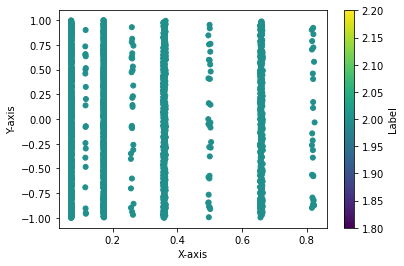

In [64]:
plot2d(X_color_yellow,'color')

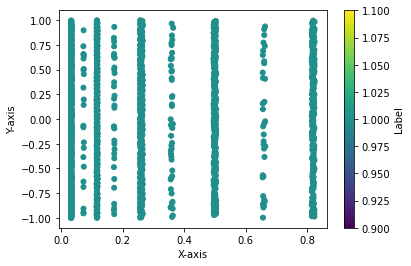

In [63]:
plot2d(X_color_green,'color')

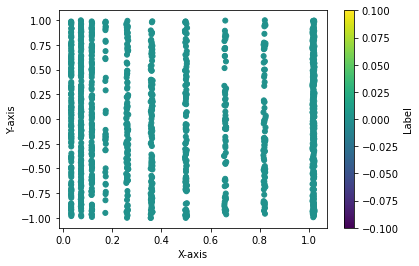

In [61]:
plot2d(X_color_purple,'color')

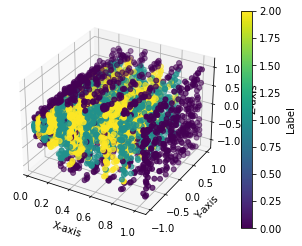

In [23]:
#Full 3d graphic for event000001000_g000.npz: 
plot3d(X_color,'color')

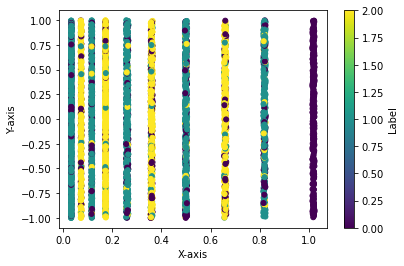

In [24]:
#Full 2d graphic for event000001000_g000.npz
plot2d(X_color,'color')

Drawing nodes...
Drawing edges...


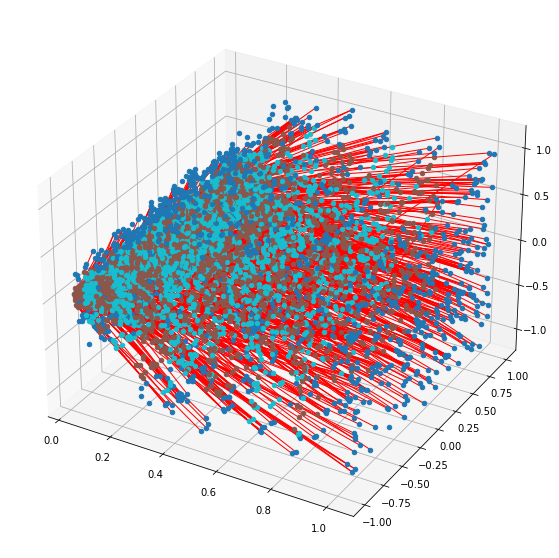

In [107]:
G = save_graph('event000001000_g000.npz')
draw_graph(G)

Drawing nodes...
Drawing edges...
Showing the graph...


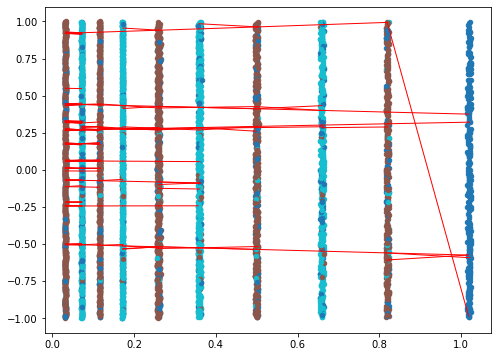

In [121]:
#Only draw 200 edges out of 10000
draw_2d_graph(G)

In [26]:
X_color=color_X_read('event000001006_g000.csv')

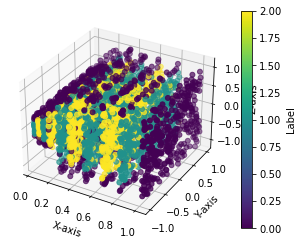

In [27]:
#Full 3d graphic for event000001006_g000.npz: 
plot3d(X_color,'color')

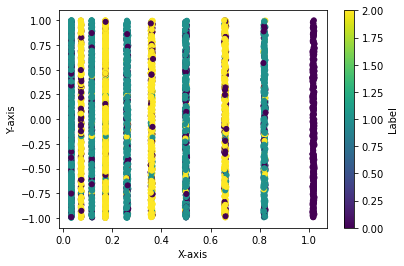

In [28]:
#Full 2d graphic for event000001006_g000.npz
plot2d(X_color,'color')

Drawing nodes...
Drawing edges...
Showing the graph...


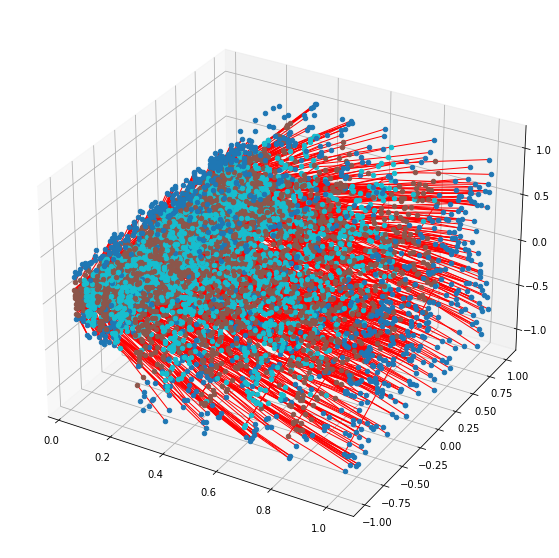

In [119]:
G = nx.read_graphml('./networks/event000001006_g000.graphml')
draw_graph(G)

In [125]:
G = nx.read_graphml('./networks/event000001010_g000.graphml')

Drawing nodes...
Drawing edges...
Showing the graph...


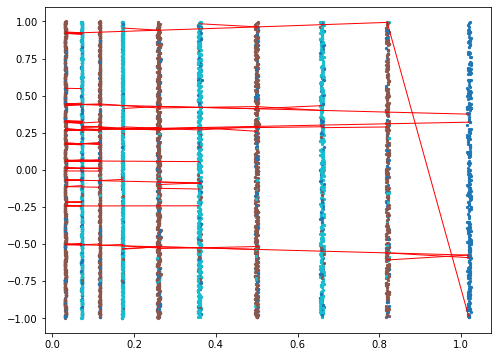

In [126]:
#Only draw 200 edges out of 10000
draw_2d_graph(G)

In [29]:
X_color = color_X_read('event000001010_g000.csv')

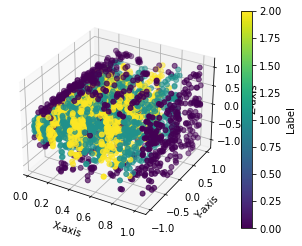

In [30]:
#Full 3d graphic for event000001010_g000.npz: 
plot3d(X_color,'color')

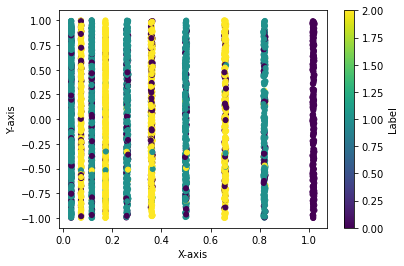

In [31]:
#Full 2d graphic for event000001010_g000.npz: 
plot2d(X_color,'color')

Drawing nodes...
Drawing edges...
Showing the graph...


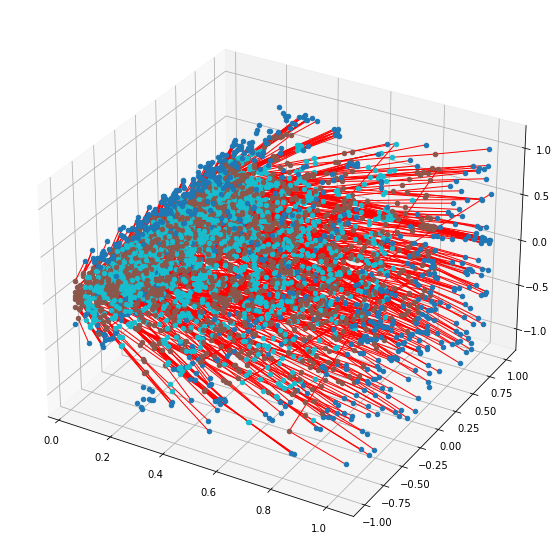

In [118]:
G=construct_graph('event000001010_g000.npz')
draw_graph(G)

Drawing nodes...
Drawing edges...
Showing the graph...


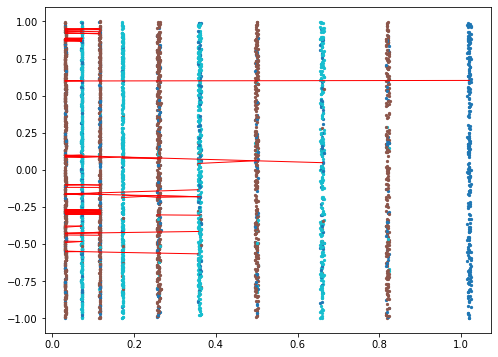

In [127]:
#Only draw 200 edges out of 10000
G=construct_graph('event000001010_g000.npz')
draw_2d_graph(G)

In [5]:
#Load raw data
graph_ex=load_graph('event000001000_g000.npz')
Ri=graph_ex.Ri
Ro=graph_ex.Ro
Ri,Ro=Ri.T,Ro.T
Rio=Ri+Ro
#Construct edge pairs
pairs=[]
for row in Rio[:100]:
    pair=[]
    for i,n in enumerate(row):
        if n==1:
            pair.append(i)
    pairs.append(pair)
len(pairs)

100

In [7]:
y=graph_ex.y
nodes_look=set()
nodes_fake=set()
real_pairs=[]
fake_pairs=[]
for i,yi in enumerate(y[:100]):
    if yi==1:
        s,e=pairs[i]
        real_pairs.append([s,e])
        nodes_look.add(str(s))
        nodes_look.add(str(e))
    else:
        nodes_fake.add(str(pairs[i][0]))
        nodes_fake.add(str(pairs[i][1]))
        fake_pairs.append(pairs[i])
nodes_look=list(nodes_look)

In [13]:
nodes_color_look=[]
nodes_color_fake=[]
graph='event000001000_g000.npz'
import json
with open("./networks/"+graph[:-4]+".json", "r") as json_file:
    node_pos,node_colors,edges= json.load(json_file)
for nd in nodes_look:
    nodes_color_look.append(node_colors[int(nd)])
for nd in nodes_fake:
    nodes_color_fake.append(node_colors[int(nd)])
node_pos_look={}
node_pos_fake={}
for nd in nodes_look:
    node_pos_look[nd]=node_pos[nd]
for nd in nodes_fake:
    node_pos_fake[nd]=node_pos[nd]
len(node_pos_look)

52

Drawing true nodes...
Drawing fake nodes...
Drawing edges...
Showing the graph...


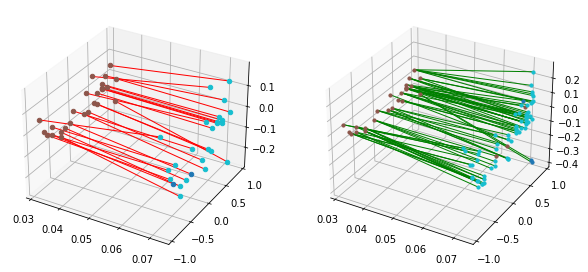

In [14]:
# Create a 3D figure
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Define a discrete colormap based on the unique colors in your data
unique_colors = set(nodes_color_look)
cmap = plt.get_cmap('tab10', len(unique_colors))  # 'tab10' is a predefined colormap
# Map unique colors to integers for discrete colormap
color_mapping = {color: i for i, color in enumerate(unique_colors)}
node_colors_mapped = [color_mapping[color] for color in nodes_color_look]
print("Drawing true nodes...")
# Draw nodes with discrete colors
for (node, pos), color in zip(node_pos_look.items(), node_colors_mapped):
    x, y, z = pos
    ax1.scatter(x, y, z, c=[cmap(color)], s=20)  # Use the discrete colormap here
print("Drawing fake nodes...")
node_colors_mapped = [color_mapping[color] for color in nodes_color_fake]
# Draw nodes with discrete colors
for (node, pos), color in zip(node_pos_fake.items(), node_colors_mapped):
    x, y, z = pos
    ax2.scatter(x, y, z, c=[cmap(color)], s=10)  # Use the discrete colormap here

print("Drawing edges...")
# Draw edges (replace with your edge drawing logic)
for u, v in real_pairs:
    u,v=str(u),str(v)
    x1, y1, z1 = node_pos_look[u]
    x2, y2, z2 = node_pos_look[v]
    ax1.plot([x1, x2], [y1, y2], [z1, z2], 'r-', linewidth=1.0)  # Customize edge appearance
for u, v in fake_pairs:
    u,v=str(u),str(v)
    x1, y1, z1 = node_pos_fake[u]
    x2, y2, z2 = node_pos_fake[v]
    ax2.plot([x1, x2], [y1, y2], [z1, z2], 'g-', linewidth=1.0)  # Customize edge appearance
print("Showing the graph...")
plt.show()